In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 350
LOOK_AHEAD_LENGTH = 3

# Train Model

In [2]:
def shapeData(data, length, look_ahead_length):
    """
    Returns a tuple of hist and target, the two datasets needed for training/testing
    params:
        data                a numpy array of the data: 1D
        length              an int, how many past frames should be used in prediction
        look_ahead_length   how many future frames ahead to predict each time
    """
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length:i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)

    # print(hist[0][length-1])
    # print(target[0][0])
    # print(data[length-1:length+1])

    # print(hist[100][length-1])
    # print(target[100][0])
    # print(data[100+length-1:100+length+1])

    # print("Target 0", target[0])
    # print("Target 0 reshape", target.reshape(-1,1))
    # print("Target 0 reshape size", target.reshape(-1,1).shape)
    # target = target.reshape(-1,1)

    #Reshape the input into (len(dataset), length, 1)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [3]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = shapeData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile if not already passed a model
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=64, input_shape=(length,1), dropout=0.05, activation='relu'))
            model.add(layers.RepeatVector(LOOK_AHEAD_LENGTH))
            model.add(layers.LSTM(units=64, return_sequences=True, dropout=0.05, activation='relu'))
            model.add(layers.TimeDistributed(layers.Dense(64, activation='relu')))
            model.add(layers.TimeDistributed(layers.Dense(1)))
            model.compile(optimizer='adam', loss='mean_squared_error')
            print(model.summary())

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=output, shuffle=False)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [4]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        
        new_df = pd.DataFrame()
        new_df["price"] = pd.read_csv(path)[["high_price","low_price"]].mean(axis=1)
        
        datasets.append(new_df)

        scaler = scaler.partial_fit(datasets[-1])
    for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)


In [5]:
def preprocess(interest_df, alt_dataframe):
    # Use ETH and LTC
    return_df = pd.DataFrame()
    return_df["price"] = raw_dataframe[["high_price","low_price"]].mean(axis=1).tail(15000)
    return_df["ema75"] = return_df["price"].ewm(span=75, adjust=False).mean()
    return_df["ema15"] = return_df["price"].ewm(span=15, adjust=False).mean()
    return_df["ema5"] = return_df["price"].ewm(span=5, adjust=False).mean()
    return_df["related_price"] = alt_dataframe[["high_price","low_price"]].mean(axis=1).tail(15000)

In [51]:
paths = ["../../data/ETH.csv"]

datasets, scaler = scaleData(paths)

# X_train, y_train = preprocessTestingData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)


model = trainModel(datasets, LENGTH)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 200)            320800    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 3, 100)            20100     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 3, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Data cardinality is ambiguous:
  x sizes: 22067
  y sizes: 66201
Make sure all arrays contain the same number of samples.

# Test Model
## Evaluation Helpers

In [50]:
def sub_sample(arr1, arr2):
    return (arr1, arr2)

def evaluate_model(real_data, predicted_data, inherent_loss):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    profit = 0
    for i in range(len(real_data)-1-LOOK_AHEAD_LENGTH):
        if np.sign(real_diff[i+LOOK_AHEAD_LENGTH-1]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if predicted_diff[i] > 1.75:
                # we subtract inherent_loss due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                if revenue > 0:
                    # print(f"Found a profit where current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > 0:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                # print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit)


In [51]:
def eval_model_on_dataset(actual, prediction, inherent_loss):
    # Subsample the test points, this seems to increase accuracy
    real_subbed, pred_subbed = sub_sample(actual, prediction)

    # Determine the number of cases in which we predicted a correct increase
    correct_slopes, profit = evaluate_model(real_subbed, pred_subbed, inherent_loss)

    print(f"Found {correct_slopes} out of {len(real_subbed)-1}")
    precent_success = (correct_slopes/(len(real_subbed)-1)) * 100
    print(f"{precent_success}%")
    print("Profit:", profit)
    return profit

## Test Model

In [52]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = shapeData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    print(pred)
    # for p in pred:
    # pred_transformed.append(scaler.inverse_transform(p))
    pred_transformed = scaler.inverse_transform(pred[0])
    actual_transformed = scaler.inverse_transform(actual[0])
    hist_transformed = scaler.inverse_transform(hist[0])

    # print(hist[0])
    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(40,50),pred_transformed, color='red', label='Prediction')
        plt.plot(np.arange(40,50),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return #eval_model_on_dataset(actual=actual_transformed, prediction=pred_transformed, inherent_loss=1.5)


Target 0 [[0.32076826]
 [0.32743514]
 [0.3213573 ]
 [0.31968389]
 [0.32272887]
 [0.32028632]
 [0.30803693]
 [0.29041924]
 [0.29080747]
 [0.28196444]]
Target 0 reshape [[0.32076826]
 [0.32743514]
 [0.3213573 ]
 ...
 [0.84695632]
 [0.85132058]
 [0.84755875]]
Target 0 reshape size (215700, 1)
[[[0.7562998 ]
  [0.79042786]
  [0.8042619 ]
  ...
  [0.81373996]
  [0.8137897 ]
  [0.8138296 ]]

 [[0.75665134]
  [0.79075736]
  [0.8045787 ]
  ...
  [0.8140145 ]
  [0.8140659 ]
  [0.81410843]]

 [[0.7571019 ]
  [0.791181  ]
  [0.8049855 ]
  ...
  [0.8143692 ]
  [0.8144205 ]
  [0.8144632 ]]

 ...

 [[0.8448071 ]
  [0.8687231 ]
  [0.875553  ]
  ...
  [0.8736394 ]
  [0.8734214 ]
  [0.87332195]]

 [[0.84486365]
  [0.8687723 ]
  [0.87559587]
  ...
  [0.8736748 ]
  [0.87345666]
  [0.873357  ]]

 [[0.8448775 ]
  [0.86878526]
  [0.87560654]
  ...
  [0.8736822 ]
  [0.8734639 ]
  [0.87336415]]]


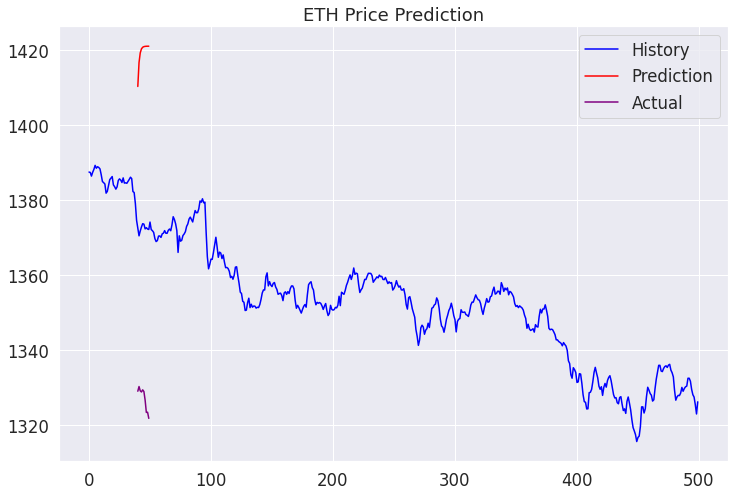

In [53]:
testModel(model, "../../data/ETH.csv")

# Single Prediction

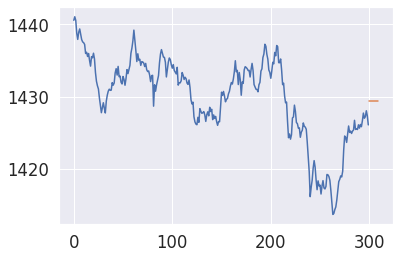

In [7]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
whole_df = pd.read_csv('../../data/ETH.csv')
# most_recent_period = np.array(recent_history)
recent_history = pd.DataFrame({'price': whole_df[["high_price","low_price"]].mean(axis=1)}).tail(length)
recent_history = recent_history.set_index(pd.DatetimeIndex(pd.to_datetime(whole_df['begins_at'].tail(length))))

# 2. convert to numpy array 
most_recent_period = np.array(recent_history)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)
# print(prediction[0])
# 6. Un-normalize the data
result = scaler.inverse_transform(prediction[0])
recent_history_unscaled = scaler.inverse_transform(most_recent_period_scaled)
recent_history.price = recent_history_unscaled

# print(result)
pred_df = pd.DataFrame(result)
# pred_df = pred_df.set_index(pd.DatetimeIndex(pd.date_range(recent_history.index[-1], periods=len(result[0]), freq="15s")))

plt.plot(recent_history_unscaled)
plt.plot(np.arange(length, length+LOOK_AHEAD_LENGTH),result)
plt.show()

# Prediction Success Evaluation

In [55]:
# model.save("encoder-decoder-40back-10forward")

INFO:tensorflow:Assets written to: encoder-decoder-40back-10forward/assets


In [3]:
# model = models.load_model("encoder-decoder-40back-10forward")

In [57]:
# profits = []
# for length in np.arange(5, 360, 5):
#     for sub in np.arange(10, 480, 5):
#         try:
#             LENGTH = length
#             SUBSAMPLING = sub
#             model = trainModel(datasets, LENGTH, quiet=True)
#             profit = testModel(model, "../../data/MorningTest.csv", quiet=True)
#             profits.append((profit, length, sub))
#             print(sorted(profits, key=lambda tup: -tup[0])[0:20])
#         except:
#             pass


Target 0 [[0.64350943]
 [0.63941292]
 [0.64156827]
 [0.64050001]
 [0.63840887]
 [0.63017568]
 [0.62040668]
 [0.61879647]
 [0.61688734]
 [0.60380268]]
Target 0 reshape [[0.64350943]
 [0.63941292]
 [0.64156827]
 ...
 [0.84695632]
 [0.85132058]
 [0.84755875]]
Target 0 reshape size (220650, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 200)           320800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 100)           20100     
_________________________________________________________________
time_distributed_11 (TimeDi

In [ ]:
# print("FINAL RESULTS")
# sorted(profits, key=lambda tup: tup[0])[0:20]
